In [1]:
# pip install tensorflow==2.16.1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf


In [3]:
import keras
print(keras.__version__)

2.15.0


In [4]:
import sklearn
print(sklearn.__version__)



1.2.2


In [5]:
import matplotlib
print(matplotlib.__version__)


3.7.1


In [6]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import pickle
import random
import os

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# Load and preprocess data (same as before)

# Load data
bruised_data = pd.read_csv('ab1.csv')
non_bruised_data = pd.read_csv('anb1.csv')

# Ensure all data has the same number of columns (features)
num_features = min(bruised_data.shape[1], non_bruised_data.shape[1])
bruised_data = bruised_data.iloc[:, :num_features]
non_bruised_data = non_bruised_data.iloc[:, :num_features]

# Add labels
bruised_data['label'] = 0  # Bruised
non_bruised_data['label'] = 1  # Non-bruised

# Combine the datasets
all_data = pd.concat([bruised_data, non_bruised_data], axis=0)

# Shuffle the combined data
all_data_shuffled = all_data.sample(frac=1, random_state=42)  # Shuffle all data

# Separate features and labels from shuffled data
X = all_data_shuffled.iloc[:, 1:-1].values  # Assuming the first column isn't relevant; adjust if needed
y = all_data_shuffled.iloc[:, -1].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save the scaler for later use
pickle.dump(scaler, open('scaler2.pkl', 'wb'))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert labels to categorical (one-hot encoding)
num_classes = 2  # Binary classification
y_resampled = to_categorical(y_resampled, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Apply ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Convert labels to categorical (one-hot encoding)
num_classes = 2
y_resampled = to_categorical(y_resampled, num_classes=num_classes)

# Define the model
def create_model(input_shape):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Implement k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store the results of each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_resampled, np.argmax(y_resampled, axis=1)), 1):
    print(f'Fold {fold}')

    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    model = create_model((X_train.shape[1],))

    # Calculate class weights
    class_weights = {0: len(y_train) / (2 * np.sum(y_train[:, 0])),
                     1: len(y_train) / (2 * np.sum(y_train[:, 1]))}

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    y_pred_prob = model.predict(X_val)

    # Find optimal threshold
    thresholds = np.arange(0, 1, 0.01)
    f1_scores_threshold = []
    for threshold in thresholds:
        y_pred_labels = (y_pred_prob[:, 1] > threshold).astype(int)
        f1_scores_threshold.append(f1_score(np.argmax(y_val, axis=1), y_pred_labels))

    optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
    print(f"Optimal threshold: {optimal_threshold}")

    # Use optimal threshold for predictions
    y_pred_labels = (y_pred_prob[:, 1] > optimal_threshold).astype(int)
    y_true = np.argmax(y_val, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    print(f"Confusion Matrix:\n{cm}")

# Print average results
print("\nAverage Results:")
print(f"Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Precision: {np.mean(precisions):.4f} (+/- {np.std(precisions):.4f})")
print(f"Recall: {np.mean(recalls):.4f} (+/- {np.std(recalls):.4f})")
print(f"F1 Score: {np.mean(f1_scores):.4f} (+/- {np.std(f1_scores):.4f})")

# Train the final model on all data
final_model = create_model((X_resampled.shape[1],))
final_model.fit(
    X_resampled, y_resampled,
    batch_size=32,
    epochs=200,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Save the final model
final_model.save('model2.h5')

# Save the scaler
pickle.dump(scaler, open('scaler2.pkl', 'wb'))

Fold 1
Epoch 1/200
11/11 [==============================] - 5s 38ms/step - loss: 4.1975 - accuracy: 0.5142 - val_loss: 3.8231 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 3.9861 - accuracy: 0.6023 - val_loss: 3.7865 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 3.8605 - accuracy: 0.6506 - val_loss: 3.7331 - val_accuracy: 0.5227 - lr: 0.0010
Epoch 4/200
11/11 [==============================] - 0s 9ms/step - loss: 3.9118 - accuracy: 0.5994 - val_loss: 3.6790 - val_accuracy: 0.5568 - lr: 0.0010
Epoch 5/200
11/11 [==============================] - 0s 9ms/step - loss: 3.7299 - accuracy: 0.6676 - val_loss: 3.6262 - val_accuracy: 0.6591 - lr: 0.0010
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 3.6497 - accuracy: 0.6733 - val_loss: 3.5718 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - 

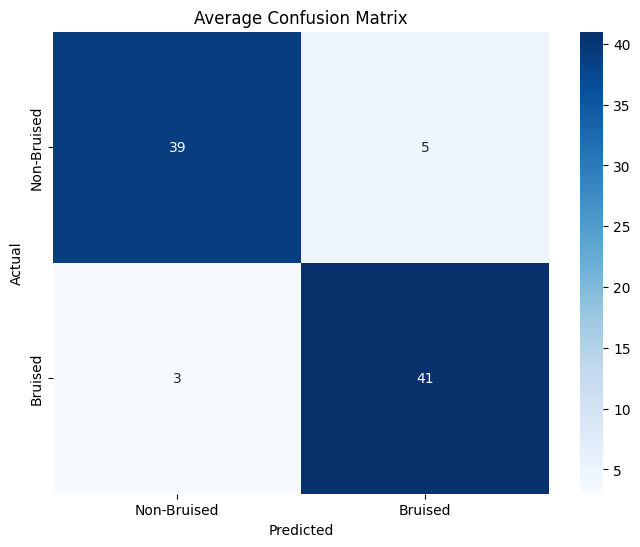


Average Results:
Accuracy: 0.9091 (+/- 0.0161)
Precision: 0.8928 (+/- 0.0304)
Recall: 0.9318 (+/- 0.0287)
F1 Score: 0.9112 (+/- 0.0152)

Average Confusion Matrix:
[[39  5]
 [ 3 41]]
True Positives (TP): 41
True Negatives (TN): 39
False Positives (FP): 5
False Negatives (FN): 3


In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import pickle
import random
import os

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

# Your data loading and preprocessing code here...

# Compute confusion matrix and other metrics for each fold
confusion_matrices = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_resampled, np.argmax(y_resampled, axis=1)), 1):
    print(f'Fold {fold}')

    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    model = create_model((X_train.shape[1],))

    # Calculate class weights
    class_weights = {0: len(y_train) / (2 * np.sum(y_train[:, 0])),
                     1: len(y_train) / (2 * np.sum(y_train[:, 1]))}

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=200,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    y_pred_prob = model.predict(X_val)

    # Find optimal threshold
    thresholds = np.arange(0, 1, 0.01)
    f1_scores_threshold = []
    for threshold in thresholds:
        y_pred_labels = (y_pred_prob[:, 1] > threshold).astype(int)
        f1_scores_threshold.append(f1_score(np.argmax(y_val, axis=1), y_pred_labels))

    optimal_threshold = thresholds[np.argmax(f1_scores_threshold)]
    print(f"Optimal threshold: {optimal_threshold}")

    # Use optimal threshold for predictions
    y_pred_labels = (y_pred_prob[:, 1] > optimal_threshold).astype(int)
    y_true = np.argmax(y_val, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    confusion_matrices.append(cm)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Average confusion matrix
avg_confusion_matrix = np.mean(confusion_matrices, axis=0).astype(int)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Non-Bruised', 'Bruised'], yticklabels=['Non-Bruised', 'Bruised'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Average Confusion Matrix')
plt.show()

# Print average results
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print("\nAverage Results:")
print(f"Accuracy: {average_accuracy:.4f} (+/- {np.std(accuracies):.4f})")
print(f"Precision: {average_precision:.4f} (+/- {np.std(precisions):.4f})")
print(f"Recall: {average_recall:.4f} (+/- {np.std(recalls):.4f})")
print(f"F1 Score: {average_f1_score:.4f} (+/- {np.std(f1_scores):.4f})")
print(f"\nAverage Confusion Matrix:\n{avg_confusion_matrix}")
print(f"True Positives (TP): {avg_confusion_matrix[1, 1]}")
print(f"True Negatives (TN): {avg_confusion_matrix[0, 0]}")
print(f"False Positives (FP): {avg_confusion_matrix[0, 1]}")
print(f"False Negatives (FN): {avg_confusion_matrix[1, 0]}")
